In [1]:
# Importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc

In [2]:
# Loading the data set
df = pd.read_csv('cms_Hbb.csv')

In [3]:
# Cleaning data set again
# Replace -1 with NaN in affected columns
df['tau_vertexEnergyRatio_0'].replace(-1, np.nan, inplace=True)
df['tau_vertexEnergyRatio_1'].replace(-1, np.nan, inplace=True)

# Drop rows where there is NaN
df.dropna(subset=['tau_vertexEnergyRatio_0', 'tau_vertexEnergyRatio_1'], inplace=True)

In [4]:
# Creating a feature data frame without the index column and the label columns
features = df.drop(columns=['Unnamed: 0', 'isBackground', 'isSignal'])

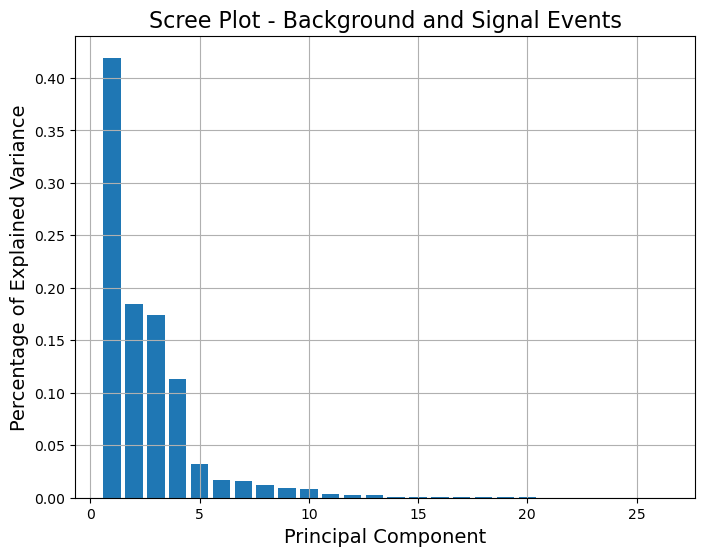

In [5]:
# Select numerical features only (excluding labels/index)
X_all = df.drop(columns=['Unnamed: 0', 'isSignal', 'isBackground'])



# PCA
pca = PCA()
X_pca = pca.fit_transform(X_all)

# Scree plot
plt.figure(figsize=(8, 6))
plt.bar(np.arange(1, len(pca.explained_variance_ratio_) + 1), pca.explained_variance_ratio_)
plt.xlabel('Principal Component', fontsize=14)
plt.ylabel('Percentage of Explained Variance', fontsize=14)
plt.title('Scree Plot - Background and Signal Events', fontsize=16)
plt.grid(True)
plt.show()

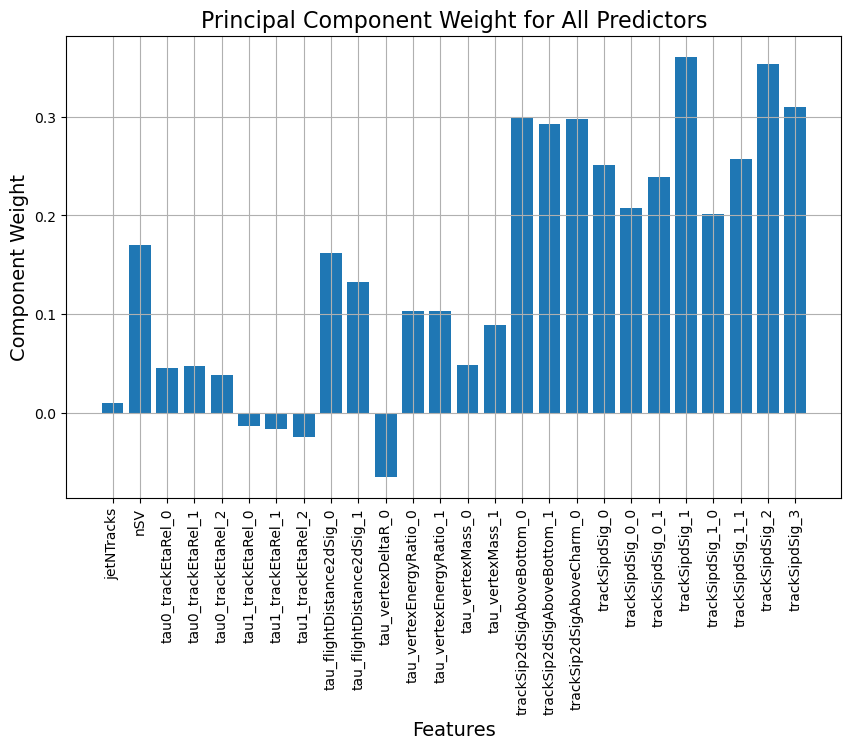

In [21]:
# Bar plot of component weights for the first principal component

plt.figure(figsize=(10, 6))
plt.bar(np.arange(len(X_all.columns)), pca.components_[0])
plt.xticks(ticks=np.arange(len(X_all.columns)), labels=X_all.columns, rotation=90)
plt.xlabel('Features', fontsize=14)
plt.ylabel('Component Weight', fontsize=14)
plt.title('Principal Component Weight for All Predictors', fontsize=16)
plt.grid(True)
plt.show()

From the bar plot of the component weights, it is observed that `trackSipdSig_1` and `trackSipdSig_2` have the highest positive loadings, indicating that these variables are the most influential in explaining the variance present in the background dataset. In contrast, features such as `tau_vertexDeltaR_0` and `tau1_trackEtaRel_2` have the smallest loadings, suggesting they contribute the least to the principal components.

This result shows that the track impact parameters have a strong role in distinguishing between different events in the background sample, while the track pseudorapidity variables associated with the second N-subjettiness axis are less important.

In [7]:
## Case 1

# Select features and labels
X = df.drop(columns=['Unnamed: 0', 'isBackground', 'isSignal'])
y = df['isSignal']  # Use isSignal as the target: 1 = signal, 0 = background

# Split the data set into training and testing sets (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [8]:
## Case 2

# Standardise all features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Perform full PCA
pca = PCA()
X_pca_full = pca.fit_transform(X_scaled)

# Explained variance and cumulative sum
explained_variance = pca.explained_variance_ratio_
cumulative_variance = np.cumsum(explained_variance)

# Find number of components that explain at least 85% variance
n_components_85 = np.argmax(cumulative_variance >= 0.85) + 1
print("Number of components that explain 85% variance:", n_components_85)

# Apply PCA again with the selected number of components
pca_final = PCA(n_components=n_components_85)
X_case2 = pca_final.fit_transform(X_scaled)

# Split into training and testing sets
X_case2_train, X_case2_test, y_case2_train, y_case2_test = train_test_split(
    X_case2, y, test_size=0.3, random_state=42)

Number of components that explain 85% variance: 12


In [9]:
# Count the number of signal (1) and background (0) events
class_counts = y.value_counts()
print(class_counts)

isSignal
0.0    146526
1.0     79240
Name: count, dtype: int64


There are far more background events so this will need to be under sampled.

In [10]:
# Combine features and labels for both cases
df_case1 = X.copy()
df_case1['label'] = y

df_case2 = pd.DataFrame(X_case2)
df_case2['label'] = y.values

# Defining class counts
class_counts = y.value_counts()
minority_class = class_counts.idxmin()
majority_class = class_counts.idxmax()
minority_size = class_counts.min()

# Under sample majority class for Case 1
df_case1_minority = df_case1[df_case1['label'] == minority_class]
df_case1_majority = df_case1[df_case1['label'] == majority_class].sample(n=minority_size, random_state=42)
df_case1_balanced = pd.concat([df_case1_minority, df_case1_majority]).sample(frac=1, random_state=42)

# Under sample majority class for Case 2
df_case2_minority = df_case2[df_case2['label'] == minority_class]
df_case2_majority = df_case2[df_case2['label'] == majority_class].sample(n=minority_size, random_state=42)
df_case2_balanced = pd.concat([df_case2_minority, df_case2_majority]).sample(frac=1, random_state=42)

# Extract features and labels
X_case1_balanced = df_case1_balanced.drop(columns='label')
y_case1_balanced = df_case1_balanced['label']

X_case2_balanced = df_case2_balanced.drop(columns='label')
y_case2_balanced = df_case2_balanced['label']

# Confirm class balance, should both be equal now
print("\nBalanced class distribution (Case 1):")
print(y_case1_balanced.value_counts())

print("\nBalanced class distribution (Case 2):")
print(y_case2_balanced.value_counts())


Balanced class distribution (Case 1):
label
0.0    79240
1.0    79240
Name: count, dtype: int64

Balanced class distribution (Case 2):
label
0.0    79240
1.0    79240
Name: count, dtype: int64


Standardisation ensures that all predictors contribute equally and fairly during classification. It does not change the relationship between variables or the class labels, but it makes the learning algorithm more effective. This is why I think standardisation should definitely be considered. I will standardise case 1 below.

In [11]:
# Standardising Case 1
scaler_case1 = StandardScaler()
X_case1_std = scaler_case1.fit_transform(X_case1_balanced)

In [12]:
## Splitting datasets into training and testing samples (case 1 and case 2 respectively)

# Case 1: original features
X_case1_train, X_case1_test, y_case1_train, y_case1_test = train_test_split(
    X_case1_std, y_case1_balanced, test_size=0.3, random_state=42)

# Case 2: PCA features
X_case2_train, X_case2_test, y_case2_train, y_case2_test = train_test_split(
    X_case2_balanced, y_case2_balanced, test_size=0.3, random_state=42)

**I will first do the Naive Bayes, Linear Discrimination and Logistic Regression for case 1 and then do them for case 2**

Naive Bayes Confusion Matrix:
[[21172  2575]
 [12281 11516]]

LDA Confusion Matrix:
[[19101  4646]
 [ 6439 17358]]

Logistic Regression Confusion Matrix:
[[19560  4187]
 [ 6161 17636]]


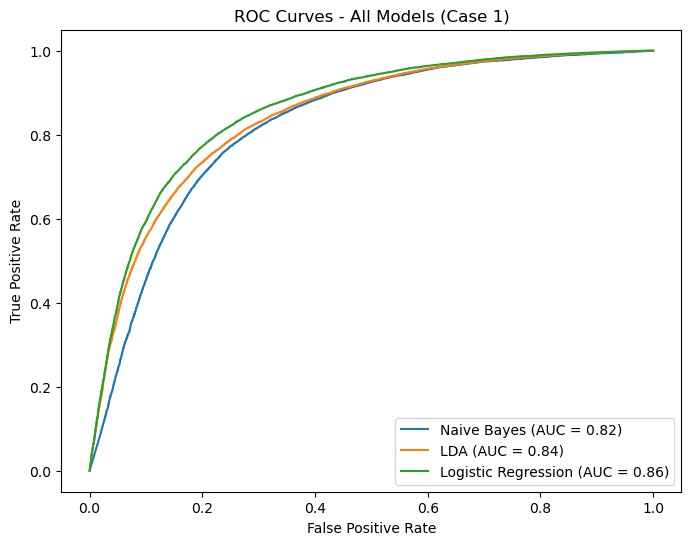

In [13]:
# CASE 1

# Naive Bayes and confusion matrix
nb = GaussianNB()
nb.fit(X_case1_train, y_case1_train)
y_pred_nb = nb.predict(X_case1_test)
y_prob_nb = nb.predict_proba(X_case1_test)[:, 1]
print("Naive Bayes Confusion Matrix:")
print(confusion_matrix(y_case1_test, y_pred_nb))

# LDA and confusion matrix
lda = LinearDiscriminantAnalysis()
lda.fit(X_case1_train, y_case1_train)
y_pred_lda = lda.predict(X_case1_test)
y_prob_lda = lda.predict_proba(X_case1_test)[:, 1]
print("\nLDA Confusion Matrix:")
print(confusion_matrix(y_case1_test, y_pred_lda))

# Logistic Regression and confusion matrix
logreg = LogisticRegression(max_iter=1000)
logreg.fit(X_case1_train, y_case1_train)
y_pred_log = logreg.predict(X_case1_test)
y_prob_log = logreg.predict_proba(X_case1_test)[:, 1]
print("\nLogistic Regression Confusion Matrix:")
print(confusion_matrix(y_case1_test, y_pred_log))

# Plot ROC Curves on same plot
fpr_nb, tpr_nb, _ = roc_curve(y_case1_test, y_prob_nb)
auc_nb = auc(fpr_nb, tpr_nb)

fpr_lda, tpr_lda, _ = roc_curve(y_case1_test, y_prob_lda)
auc_lda = auc(fpr_lda, tpr_lda)

fpr_log, tpr_log, _ = roc_curve(y_case1_test, y_prob_log)
auc_log = auc(fpr_log, tpr_log)

plt.figure(figsize=(8,6))
plt.plot(fpr_nb, tpr_nb, label='Naive Bayes (AUC = %.2f)' % auc_nb)
plt.plot(fpr_lda, tpr_lda, label='LDA (AUC = %.2f)' % auc_lda)
plt.plot(fpr_log, tpr_log, label='Logistic Regression (AUC = %.2f)' % auc_log)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models (Case 1)')
plt.legend()
plt.show()


Naive Bayes Confusion Matrix (Case 2):
[[21038  2709]
 [13913  9884]]

LDA Confusion Matrix (Case 2):
[[18903  4844]
 [ 6392 17405]]

Logistic Regression Confusion Matrix (Case 2):
[[19406  4341]
 [ 6211 17586]]


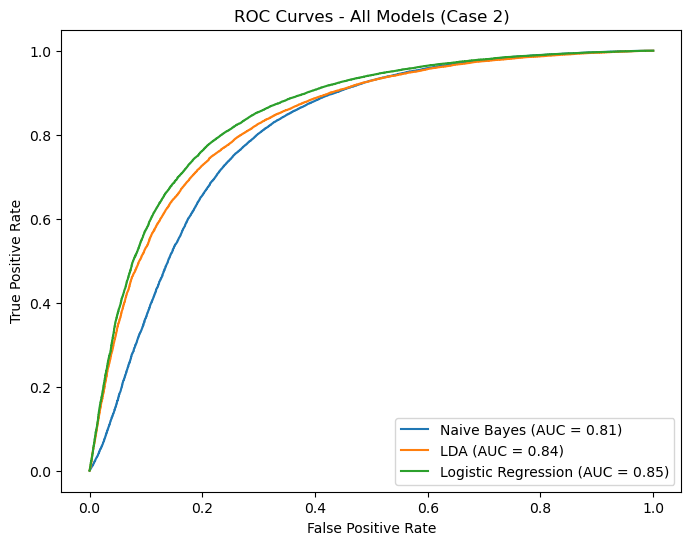

In [14]:
# CASE 1


# Naive Bayes and confusion matrix
nb2 = GaussianNB()
nb2.fit(X_case2_train, y_case2_train)
y_pred_nb2 = nb2.predict(X_case2_test)
y_prob_nb2 = nb2.predict_proba(X_case2_test)[:, 1]
print("\nNaive Bayes Confusion Matrix (Case 2):")
print(confusion_matrix(y_case2_test, y_pred_nb2))

# LDA
lda2 = LinearDiscriminantAnalysis()
lda2.fit(X_case2_train, y_case2_train)
y_pred_lda2 = lda2.predict(X_case2_test)
y_prob_lda2 = lda2.predict_proba(X_case2_test)[:, 1]
print("\nLDA Confusion Matrix (Case 2):")
print(confusion_matrix(y_case2_test, y_pred_lda2))

# Logistic Regression
logreg2 = LogisticRegression(max_iter=1000)
logreg2.fit(X_case2_train, y_case2_train)
y_pred_log2 = logreg2.predict(X_case2_test)
y_prob_log2 = logreg2.predict_proba(X_case2_test)[:, 1]
print("\nLogistic Regression Confusion Matrix (Case 2):")
print(confusion_matrix(y_case2_test, y_pred_log2))

# Plot ROC Curves Together - Case 2
fpr_nb2, tpr_nb2, _ = roc_curve(y_case2_test, y_prob_nb2)
auc_nb2 = auc(fpr_nb2, tpr_nb2)

fpr_lda2, tpr_lda2, _ = roc_curve(y_case2_test, y_prob_lda2)
auc_lda2 = auc(fpr_lda2, tpr_lda2)

fpr_log2, tpr_log2, _ = roc_curve(y_case2_test, y_prob_log2)
auc_log2 = auc(fpr_log2, tpr_log2)

plt.figure(figsize=(8,6))
plt.plot(fpr_nb2, tpr_nb2, label='Naive Bayes (AUC = %.2f)' % auc_nb2)
plt.plot(fpr_lda2, tpr_lda2, label='LDA (AUC = %.2f)' % auc_lda2)
plt.plot(fpr_log2, tpr_log2, label='Logistic Regression (AUC = %.2f)' % auc_log2)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves - All Models (Case 2)')
plt.legend()
plt.show()

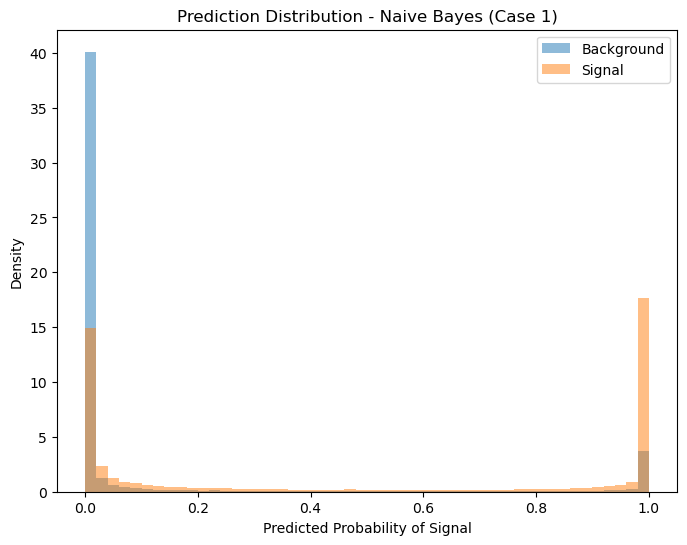

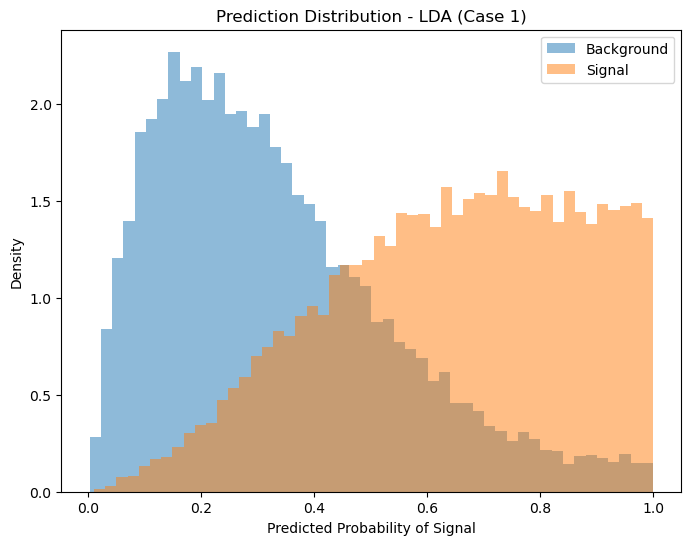

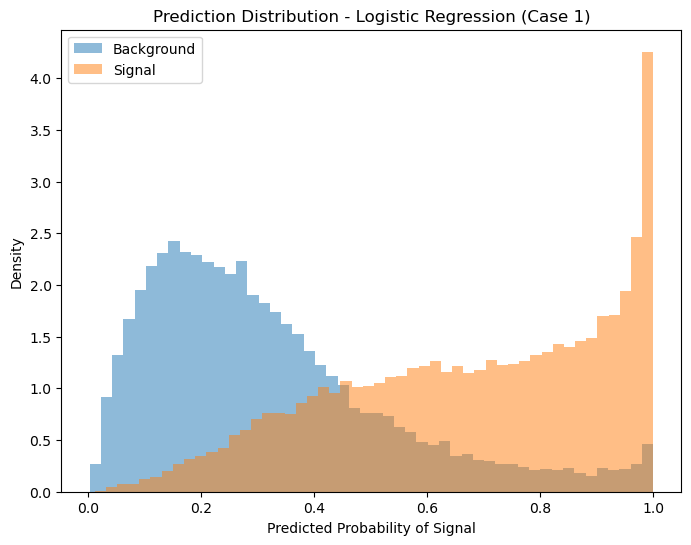

In [15]:
## Classification outcome plotting for case 1


# creating a dictionary so that the models can be looped over for each case efficiently
models = {
    'Naive Bayes': GaussianNB(),
    'LDA': LinearDiscriminantAnalysis(),
    'Logistic Regression': LogisticRegression(max_iter=1000)}


for name, model in models.items(): # looping over models
    model.fit(X_case1_train, y_case1_train)
    # Predict probabilities
    y_prob = model.predict_proba(X_case1_test)[:, 1]

    # Direct filtering without masks
    y_prob_background = y_prob[y_case1_test == 0]
    y_prob_signal = y_prob[y_case1_test == 1]

    # Plot
    plt.figure(figsize=(8, 6))
    plt.hist(y_prob_background, bins=50, alpha=0.5, label='Background', density=True)
    plt.hist(y_prob_signal, bins=50, alpha=0.5, label='Signal', density=True)
    plt.xlabel('Predicted Probability of Signal')
    plt.ylabel('Density')
    plt.title(f'Prediction Distribution - {name} (Case 1)')
    plt.legend()
    plt.show()

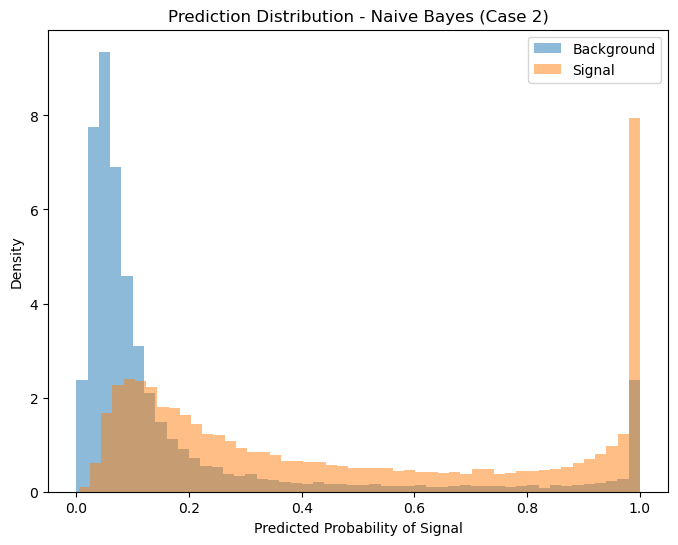

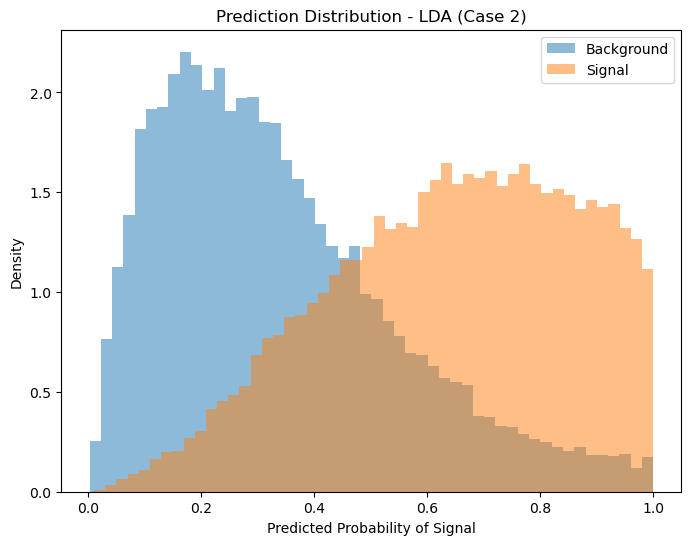

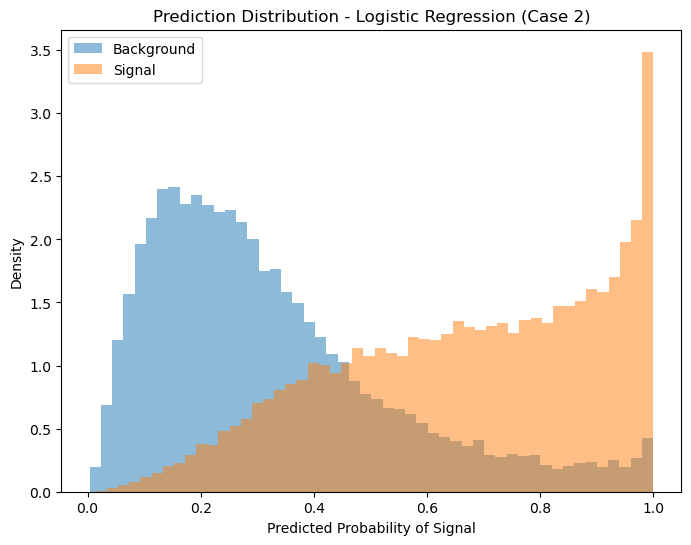

In [16]:
## Classification outcome plotting for case 2

for name, model in models.items():
    model.fit(X_case2_train, y_case2_train)
    y_prob = model.predict_proba(X_case2_test)[:, 1]

    y_prob_background = y_prob[y_case2_test == 0]
    y_prob_signal = y_prob[y_case2_test == 1]

    plt.figure(figsize=(8, 6))
    plt.hist(y_prob_background, bins=50, alpha=0.5, label='Background', density=True)
    plt.hist(y_prob_signal, bins=50, alpha=0.5, label='Signal', density=True)
    plt.xlabel('Predicted Probability of Signal')
    plt.ylabel('Density')
    plt.title(f'Prediction Distribution - {name} (Case 2)')
    plt.legend()
    plt.show()

I considered restricting the input variables to a subset to reduce dimensionality and improve classifier performance. Based on the PCA component loadings and the correlation heatmap, some features (such as `tau1_trackEtaRel_0` and `tau1_trackEtaRel_2`) contributed very little to the variance and were weakly correlated with other predictors.

Their class distributions were nearly identical for signal and background events, providing limited discriminative power. For this reason, I considered excluding these features from the model input, though ultimately kept the full set for consistency and comparison.

## Punzi significance threshold optimisation

Based on the AUC scores from the ROC curves, Logistic Regression using the original feature set (Case 1) achieved the highest performance with an AUC of 0.86. This outperformed both Naive Bayes and Linear Discriminant Analysis across both Case 1 and Case 2.The the classification outcome histograms for Logistic Regression (Case 1) showed the clearest separation between signal and background probabilities, indicating strong discriminative power. For this rea as well the AUC score and confusion matrix calculated earlier,sted Logistic Regression from Ca was selectedse 1 as the model for final threshold optimisation using the Punzi significance.

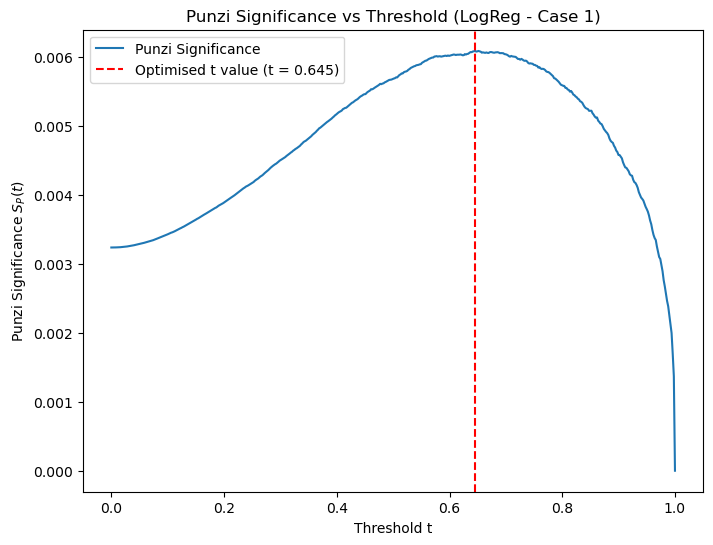

Optimal t value for max Punzi significance: 0.645
Maximum Punzi significance: 0.0061


In [17]:
# Threshold optimisation using Punzi significance

# Predict probabilities for test set
y_prob = logreg.predict_proba(X_case1_test)[:, 1]

# Separate signal and background
signal = y_case1_test == 1
background = y_case1_test == 0

# Prepare sweep
thresholds = np.linspace(0, 1, 500)
punzi = []
p = 2

for t in thresholds:
    eps = np.sum(y_prob[signal] > t) / np.sum(signal)
    B = np.sum(y_prob[background] > t)
    if B > 0:
        sp = eps / (1 + p * np.sqrt(B))
    else:
        sp = 0
    punzi.append(sp)

# Find max
punzi = np.array(punzi)
best_idx = np.argmax(punzi)
best_t = thresholds[best_idx]
best_sp = punzi[best_idx]

# Plot
plt.figure(figsize=(8,6))
plt.plot(thresholds, punzi, label='Punzi Significance')
plt.axvline(best_t, color='r', linestyle='--', label='Optimised t value (t = %.3f)' % best_t)
plt.xlabel('Threshold t')
plt.ylabel('Punzi Significance $S_P(t)$')
plt.title('Punzi Significance vs Threshold (LogReg - Case 1)')
plt.legend()
plt.show()

# Print optimal threshold
print("Optimal t value for max Punzi significance: %.3f" % best_t)
print("Maximum Punzi significance: %.4f" % best_sp)

Using the predicted probabilities from the logistic regression classifier (Case 1), I evaluated the Punzi significance across a range of thresholds from 0 to 1.

The Punzi significance was maximised at a threshold value of t = 0.645, corresponding to a maximum significance of 0.0061. This indicates that using a classification cutoff of 0.645 would yield the best sensitivity to signal events.